In [ ]:
import re
import pickle
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
!pip install -q catboost optuna shap phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00


(165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
151433,151433,15717307,Read,496,France,Male,31.0,3,0.00,1,0.0,0.0,93713.13,0
52257,52257,15578738,Trevisan,681,Germany,Male,35.0,5,80927.56,2,1.0,0.0,111687.57,0
44578,44578,15567147,Okechukwu,759,France,Male,32.0,7,0.00,2,1.0,1.0,136985.08,0


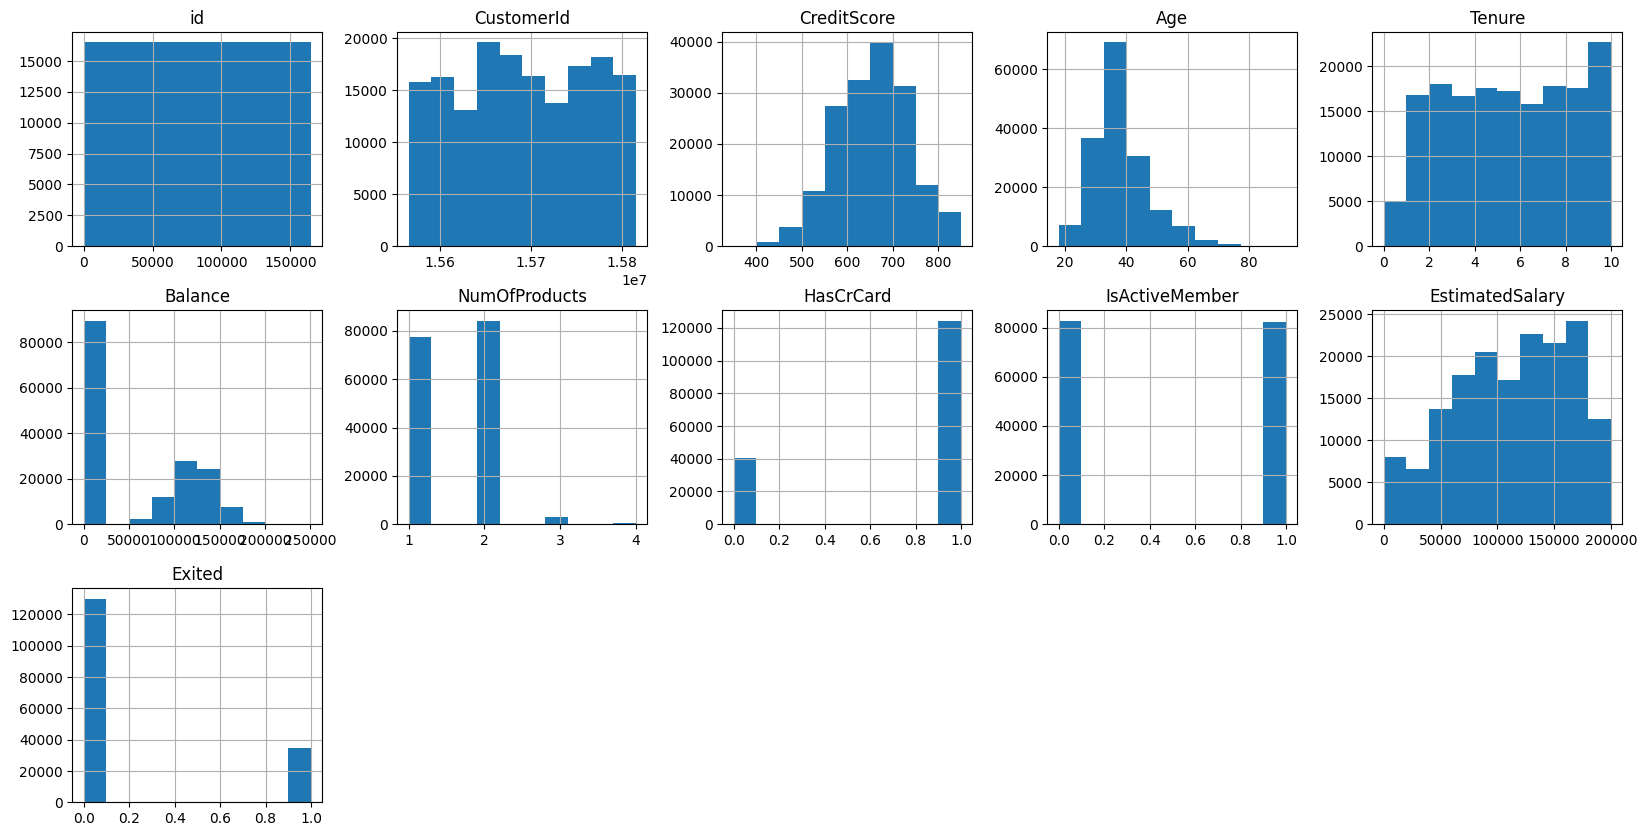

In [ ]:
train = pd.read_csv("train.csv")
print(train.shape)
train.hist(figsize=(20, 10), layout = (-1, 5))
train.sample(3)

In [ ]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


(110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
100157,265191,15679075,Onyemere,689,France,Male,31.0,8,107879.04,1,1.0,1.0,196894.62
406,165440,15581525,Walker,628,Germany,Female,39.0,3,121669.93,1,1.0,0.0,124429.19
80377,245411,15687952,Ch'ang,707,France,Male,30.0,1,141827.33,1,1.0,1.0,159891.72


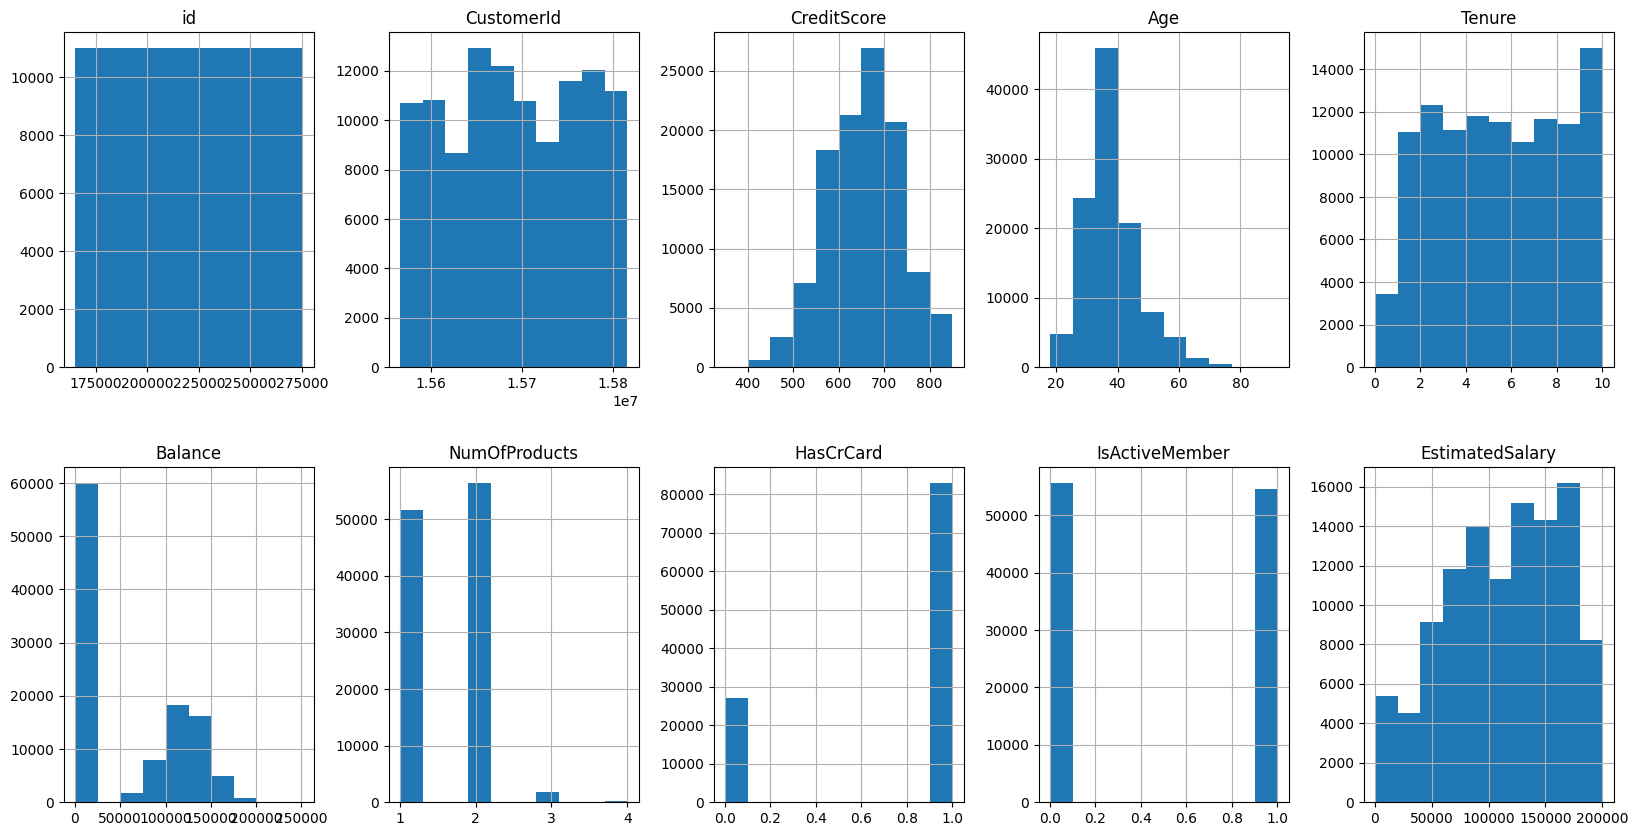

In [ ]:
test = pd.read_csv("test.csv")
print(test.shape)
test.hist(figsize=(20, 10), layout = (-1, 5))
test.sample(3)

In [ ]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [ ]:
X = train.drop(['Exited'], axis=1)
y = train['Exited']

In [ ]:
cat_features = ['Surname', 'Geography', 'Gender']
base_features = ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
target_column = ['Exited']

In [ ]:
features2drop = ["id", "Exited", "Surname", "CustomerId"]  # То, что можно выбросить
targets = ["Exited"]  # Таргеты
cat_features = ['Geography', 'Gender']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features :", len(cat_features), cat_features)
print("num_features :", len(num_features), num_features)
print("targets", targets)

cat_features : 2 ['Geography', 'Gender']
num_features : 8 ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
targets ['Exited']


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train[num_features + cat_features],
    train[target_column], test_size=0.2, random_state=42)

train_dataset = Pool(X_train, y_train, cat_features=cat_features)
val_dataset = Pool(X_val, y_val, cat_features=cat_features)

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    #loss_function='CrossEntropy'
)


clf.fit(X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 100, 'learning_rate': 0.1}


In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(
    iterations=10,
#     verbose=5,
)

clf.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
)

Learning rate set to 0.5
0:	learn: 0.4811829	test: 0.4806926	best: 0.4806926 (0)	total: 48.4ms	remaining: 436ms
1:	learn: 0.4026112	test: 0.4017476	best: 0.4017476 (1)	total: 133ms	remaining: 533ms
2:	learn: 0.3696065	test: 0.3681933	best: 0.3681933 (2)	total: 212ms	remaining: 494ms
3:	learn: 0.3526547	test: 0.3512188	best: 0.3512188 (3)	total: 306ms	remaining: 458ms
4:	learn: 0.3362029	test: 0.3345606	best: 0.3345606 (4)	total: 370ms	remaining: 370ms
5:	learn: 0.3287447	test: 0.3268838	best: 0.3268838 (5)	total: 445ms	remaining: 297ms
6:	learn: 0.3261667	test: 0.3241548	best: 0.3241548 (6)	total: 511ms	remaining: 219ms
7:	learn: 0.3242586	test: 0.3223794	best: 0.3223794 (7)	total: 586ms	remaining: 147ms
8:	learn: 0.3233939	test: 0.3214048	best: 0.3214048 (8)	total: 665ms	remaining: 73.9ms
9:	learn: 0.3224585	test: 0.3205299	best: 0.3205299 (9)	total: 738ms	remaining: 0us

bestTest = 0.3205298978
bestIteration = 9



In [ ]:
cb_init_params = {
    'eval_metric': 'RMSE',
    'thread_count': 2,
    'task_type': 'CPU',
    'random_seed': 42
}

model = CatBoostClassifier(**cb_init_params)
model.fit(train_dataset,
          eval_set=val_dataset,
          verbose=10,
          early_stopping_rounds=15)

NameError: name 'CatBoostClassifier' is not defined

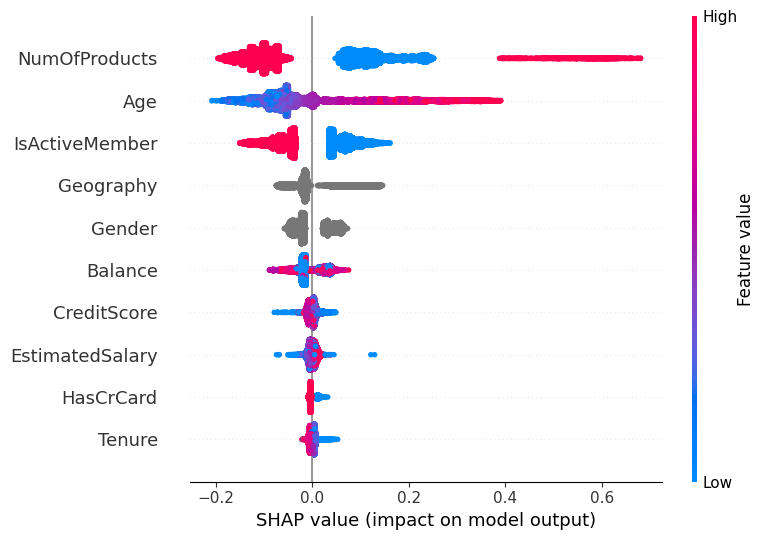

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_val)

interval columns not set, guessing: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


The number of unique values of variable Surname is large: 2797. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.


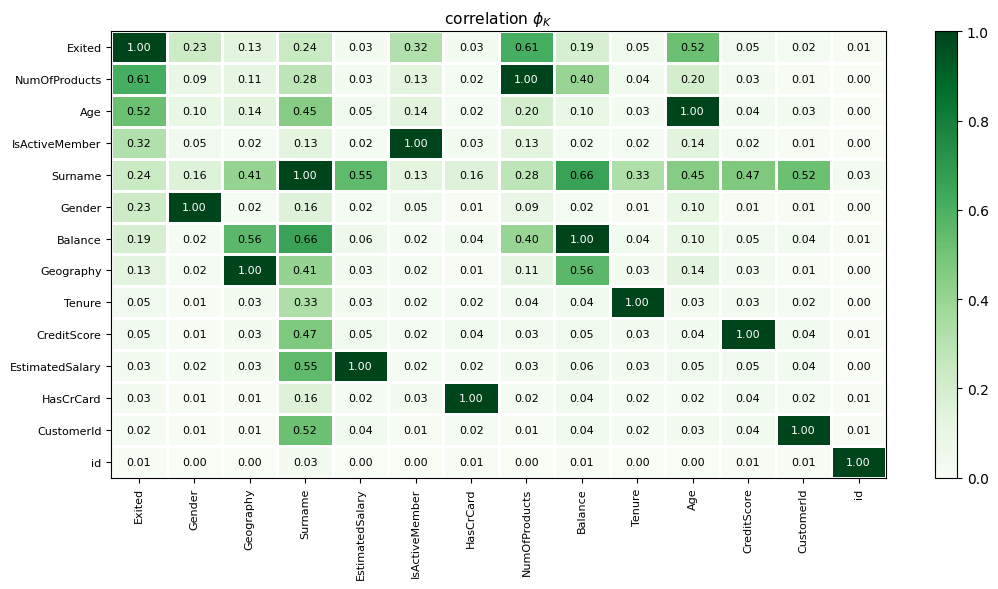

In [ ]:
phik_overview = train[base_features + cat_features + target_column] \
    .phik_matrix().round(2).sort_values('Exited')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [ ]:
X_data = train[base_features + cat_features]
y_data = train[target_column]

X_test_data = test[base_features + cat_features]

In [ ]:
lr_scaler = StandardScaler()
X_lr_data = lr_scaler.fit_transform(X_data[base_features])

X_train, X_val, y_train, y_val = train_test_split(X_lr_data, y_data, test_size=0.2, random_state=42)
X_test = lr_scaler.transform(X_test_data[base_features])

NameError: name 'X_test_data' is not defined

In [ ]:
model = LinearRegression().fit(X_train, y_train)

In [ ]:
mean_squared_error(y_val, model.predict(X_val), squared=False)

0.3665783593008863

In [ ]:
# RMSE такого решения: 14.8
pd.DataFrame({'id': test['id'],
              'Exited': model.predict(X_test).reshape(-1)}) \
        .to_csv('pred_lr_baseline_sub.csv', index=False)

In [ ]:
df = pd.read_csv("pred_lr_baseline_sub.csv")

In [ ]:
df.describe()

,id,Exited
count,110023.000000,110023.000000
mean,220045.000000,0.214990
std,31761.048671,0.180482
min,165034.000000,-0.340647
25%,192539.500000,0.084146
50%,220045.000000,0.201098
75%,247550.500000,0.331819
max,275056.000000,1.094555


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_data[base_features], y_data.iloc[:, 0], test_size=0.2, random_state=42)
X_test = X_test_data[base_features]

NameError: name 'X_test_data' is not defined

In [ ]:
model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

In [ ]:
mean_squared_error(y_val, model.predict(X_val), squared=False)

0.3310554112825728

In [ ]:
pd.DataFrame({'id': test['id'],
              'Exited': model.predict(X_test)}) \
        .to_csv('pred_rf_baseline_sub.csv', index=False)

In [ ]:
df = pd.read_csv("pred_rf_baseline_sub.csv")
df["Exited"] = df["Exited"].apply(lambda x: x > 0.3)

In [ ]:
df.head()

,id,Exited
0,165034,False
1,165035,True
2,165036,False
3,165037,False
4,165038,True


In [ ]:
df["Exited"] = df["Exited"].astype("int64")

In [ ]:
df.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,1
4,165038,1


In [ ]:
df["Exited"].value_counts()

1    59450
0    50573
Name: Exited, dtype: int64

In [ ]:
df.to_csv('sub3.csv', index=False)

In [ ]:
df = pd.read_csv("sub1.csv")

In [ ]:
df.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0


In [ ]:
df = pd.read_csv('data.csv', index_col=0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

train_dataset = Pool(X_train, y_train, cat_features=cat_features, feature_names=list(X_train))
val_dataset = Pool(X_val, y_val, cat_features=cat_features, feature_names=list(X_val))
test_dataset = Pool(X_test_data, cat_features=cat_features, feature_names=list(X_test_data))

In [ ]:
# Инициализация модели
cb_init_params = {
    'eval_metric': 'RMSE',
    'thread_count': 2,
    'task_type': 'CPU',
    'random_seed': 42
}

model = CatBoostRegressor(**cb_init_params)
model.fit(train_dataset,
          eval_set=val_dataset,
          verbose=10,
          early_stopping_rounds=15)

Learning rate set to 0.109607
0:	learn: 0.3924722	test: 0.3916912	best: 0.3916912 (0)	total: 107ms	remaining: 1m 46s
10:	learn: 0.3278605	test: 0.3270434	best: 0.3270434 (10)	total: 1.2s	remaining: 1m 47s
20:	learn: 0.3172938	test: 0.3165482	best: 0.3165482 (20)	total: 2.77s	remaining: 2m 9s
30:	learn: 0.3143623	test: 0.3133305	best: 0.3133305 (30)	total: 4.02s	remaining: 2m 5s
40:	learn: 0.3131006	test: 0.3120774	best: 0.3120774 (40)	total: 5.07s	remaining: 1m 58s
50:	learn: 0.3125029	test: 0.3115442	best: 0.3115442 (50)	total: 5.74s	remaining: 1m 46s
60:	learn: 0.3120015	test: 0.3111380	best: 0.3111380 (60)	total: 6.43s	remaining: 1m 39s
70:	learn: 0.3115783	test: 0.3108964	best: 0.3108964 (70)	total: 7.24s	remaining: 1m 34s
80:	learn: 0.3111858	test: 0.3106574	best: 0.3106574 (80)	total: 8.02s	remaining: 1m 30s
90:	learn: 0.3108767	test: 0.3104550	best: 0.3104548 (89)	total: 8.76s	remaining: 1m 27s
100:	learn: 0.3107008	test: 0.3103588	best: 0.3103588 (100)	total: 9.4s	remaining: 1m

In [ ]:
pd.DataFrame({'id': test['id'],
              'Exited': model.predict(test_dataset)}) \
        .to_csv('pred_cb_baseline_sub.csv', index=False)

In [ ]:
df = pd.read_csv("/content/pred_cb_baseline_sub.csv")

In [ ]:
df = pd.read_csv("pred_cb_baseline_sub.csv")
df["Exited"] = df["Exited"].apply(lambda x: x > 0.3)

In [ ]:
df.head()

,id,Exited
0,165034,0.033229
1,165035,0.829374
2,165036,0.016374
3,165037,0.264637
4,165038,0.379084


In [ ]:
df["Exited"] = df["Exited"].astype("int64")

In [ ]:
df["Exited"].value_counts()

0    83140
1    26883
Name: Exited, dtype: int64

In [ ]:
df.to_csv('sub4.csv', index=False)

In [ ]:
# Base CatBoost = 80%

In [ ]:
train.boxplot(
    column=["user_rating"], by="target_class", fontsize=8, figsize=(20, 5)
);

In [ ]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_features,
                           thread_count=-1)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.105855
0:	learn: 0.6015702	test: 0.6014675	best: 0.6014675 (0)	total: 119ms	remaining: 1m 58s
100:	learn: 0.3172636	test: 0.3174504	best: 0.3174504 (100)	total: 12.1s	remaining: 1m 47s
200:	learn: 0.3125458	test: 0.3167628	best: 0.3167628 (200)	total: 24.4s	remaining: 1m 37s
300:	learn: 0.3089571	test: 0.3169788	best: 0.3167213 (210)	total: 36.9s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3167213482
bestIteration = 210

Shrink model to first 211 iterations.


In [ ]:
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,NumOfProducts,43.977438
1,Age,21.128797
2,IsActiveMember,10.402741
3,Balance,8.848495
4,Geography,5.880243
5,Gender,3.649731
6,CreditScore,2.272832
7,EstimatedSalary,2.079708
8,Tenure,1.044480
9,HasCrCard,0.715534


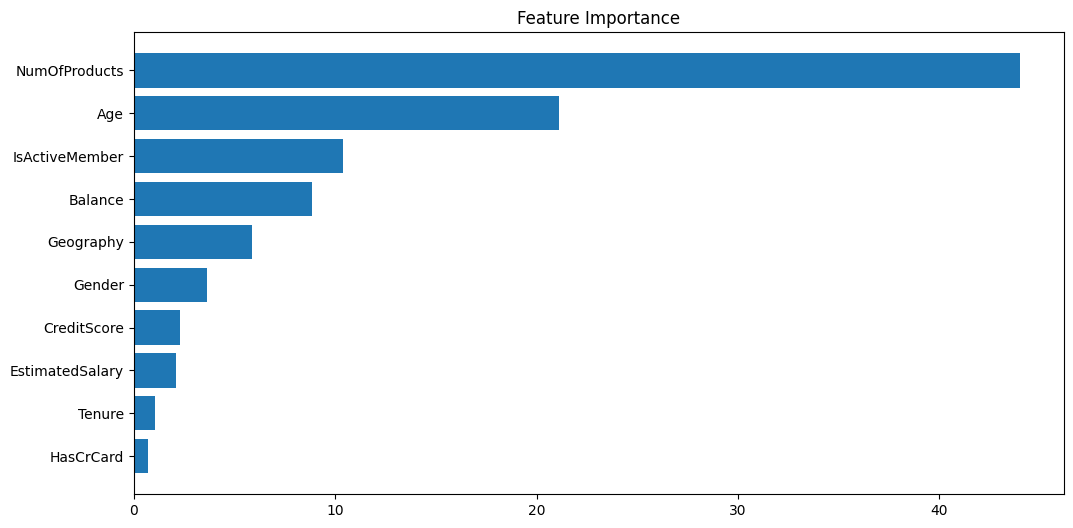

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

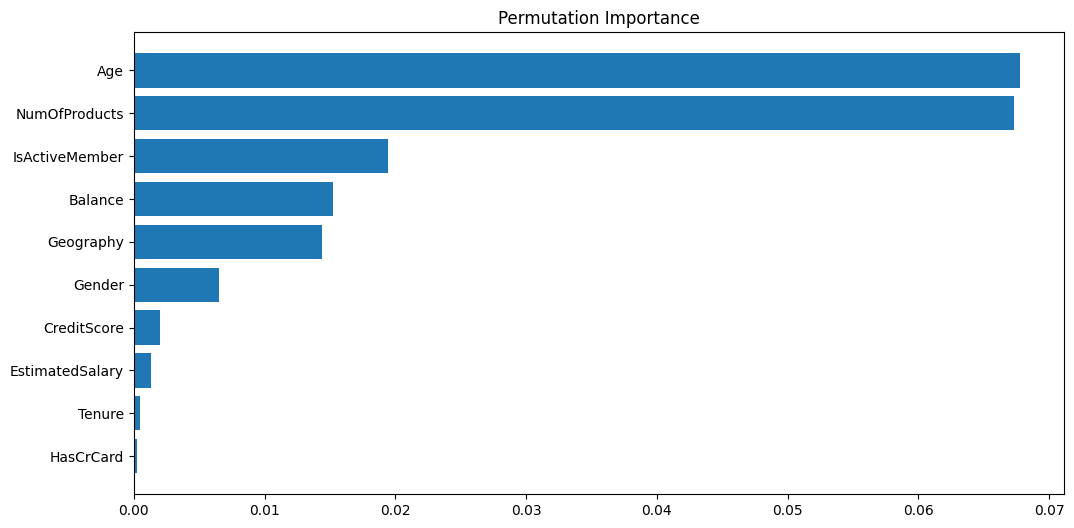

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

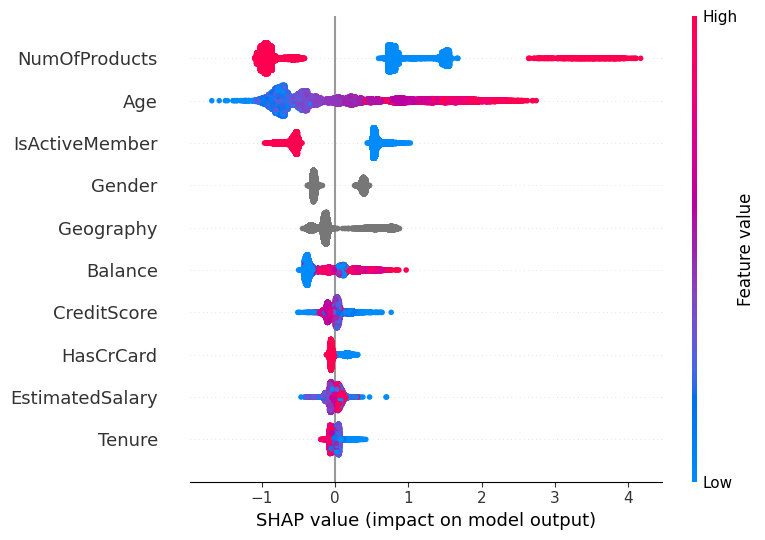

In [ ]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

In [ ]:
X_train_one_hot = pd.get_dummies(X_train[cat_features])
X_train = pd.concat((X_train.drop(columns=cat_features), X_train_one_hot), axis=1).fillna(0)
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
149380,679,41.0,9,0.00,2,1.0,1.0,103560.98,1,0,0,0,1
164766,721,46.0,9,115764.32,2,1.0,0.0,102950.79,1,0,0,0,1
155569,551,35.0,5,0.00,1,1.0,0.0,155394.52,1,0,0,0,1
124304,743,31.0,3,57866.03,2,1.0,1.0,107428.42,0,0,1,1,0
108008,675,28.0,2,0.00,2,1.0,0.0,134110.93,1,0,0,0,1


In [ ]:
important_features = ['NumOfProducts', 'Age', 'IsActiveMember', 'EstimatedSalary', 'Gender', 'Balance']

In [ ]:
!pip install boruta -q

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train.values.ravel()))
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	13
Rejected: 	0
features in the green area: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
features in the blue area: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
features in the red area: []


In [ ]:
important_features = ['NumOfProducts', 'Age', 'IsActiveMember', 'EstimatedSalary', 'Gender', 'Balance', 'Geography']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(random_state=42,
                           cat_features=['Gender', 'Geography'],
                           thread_count=-1)


model.fit(X_train[important_features], y_train,
          eval_set=(X_test[important_features], y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.105855
0:	learn: 0.6052929	test: 0.6050121	best: 0.6050121 (0)	total: 112ms	remaining: 1m 51s
100:	learn: 0.3189247	test: 0.3189629	best: 0.3189629 (100)	total: 12s	remaining: 1m 46s
200:	learn: 0.3156287	test: 0.3184416	best: 0.3184416 (200)	total: 24s	remaining: 1m 35s
300:	learn: 0.3132424	test: 0.3184943	best: 0.3184200 (237)	total: 36s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3184199721
bestIteration = 237

Shrink model to first 238 iterations.
